<a href="https://colab.research.google.com/github/xixilili/MSDS_458_Public/blob/master/MSDS458_Assignment_03/MSDS458_Assignment_03_Experiment_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Package

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Load and Process Data

In [14]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-19 00:25:44.158029: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0219 00:25:44.158329 140607014307712 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0219 00:25:44.159623 140607014307712 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0219 00:25:44.164968 140607014307712 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0219 00:25:44.165245 140607014307712 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [16]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Encoder

In [17]:
def get_encoder(VOCAB_SIZE):
  encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
  encoder.adapt(train_dataset.map(lambda text, label: text))
  return encoder

### Create Model

In [18]:
def creat_model(encoder):
  model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
  ])
  return model

### Compile, Train Model

In [19]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [20]:
import datetime as dt

def compile_train_model(model, epoch):
  #compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model  
  history = model.fit(train_dataset
                    ,epochs = epoch
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


  #evaluate model
  loss, accuracy = model.evaluate(test_dataset)
  print('test set accuracy: ', accuracy * 100)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs_setting'] = epoch  
  result['epochs_actual'] = epochs    

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs'.format(namestr(model, globals()), epoch))   
  plt.show()  

  return result

### Explore Vocab

In [21]:
def explore_vocab(train_dataset,encoder):
  doc_sizes = []
  corpus = []
  for example, _ in train_dataset.as_numpy_iterator():
    enc_example = encoder(example)
    doc_sizes.append(len(enc_example))
    corpus+=list(enc_example.numpy())
  return  corpus, doc_sizes

## Experiment A a
(a) Vocabulary Size: Tweak the vocabulary size, at least 3 levels, eg. vocab size of 1000, 2000, 3000. This way, we can get insights whether the performance metric is non linearly related to the vocab size.

### Vocab 1000

In [28]:
len(train_dataset),len(validation_dataset),len(test_dataset) 

(1782, 94, 119)

In [29]:
#for example, label in train_dataset.take(1):
#  print('text: ', example.numpy())

In [30]:
VOCAB_SIZE = 1000
EPOCH_SIZE = 200
encoder1000 = get_encoder(VOCAB_SIZE)

In [31]:
corpus1000, doc_sizes1000 = explore_vocab(train_dataset,encoder1000)

In [32]:

vocab1000 = np.array(encoder1000.get_vocabulary())
num_vocab_words_in_corpus =len(vocab1000)

num_words =len(corpus1000)
num_articles =len(doc_sizes1000)
min_token_in_a_article = min(doc_sizes1000)
max_token_in_a_article = max(doc_sizes1000)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

"""
plt.figure(figsize=(15,9))
plt.hist(doc_sizes1000, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
"""

1000
114000
1782
16
64


'\nplt.figure(figsize=(15,9))\nplt.hist(doc_sizes1000, bins=20,range = (0,120))\nplt.xlabel("Tokens Per Document")\nplt.ylabel("Number of AG News Articles")\n'

Epoch 1/200
1782/1782 [==============================] - 278s 151ms/step - loss: 0.8231 - accuracy: 0.6616 - val_loss: 0.5773 - val_accuracy: 0.7858
Epoch 2/200
1782/1782 [==============================] - 261s 146ms/step - loss: 0.4886 - accuracy: 0.8244 - val_loss: 0.4285 - val_accuracy: 0.8505
Epoch 3/200
1782/1782 [==============================] - 261s 146ms/step - loss: 0.4189 - accuracy: 0.8505 - val_loss: 0.4051 - val_accuracy: 0.8595
Epoch 4/200
1782/1782 [==============================] - 270s 151ms/step - loss: 0.4006 - accuracy: 0.8560 - val_loss: 0.3950 - val_accuracy: 0.8615
Epoch 5/200
1782/1782 [==============================] - 261s 146ms/step - loss: 0.3906 - accuracy: 0.8598 - val_loss: 0.3937 - val_accuracy: 0.8617
Epoch 6/200
1782/1782 [==============================] - 262s 147ms/step - loss: 0.3851 - accuracy: 0.8610 - val_loss: 0.3895 - val_accuracy: 0.8635
Epoch 7/200
1782/1782 [==============================] - 260s 146ms/step - loss: 0.3805 - accuracy: 0.8623

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

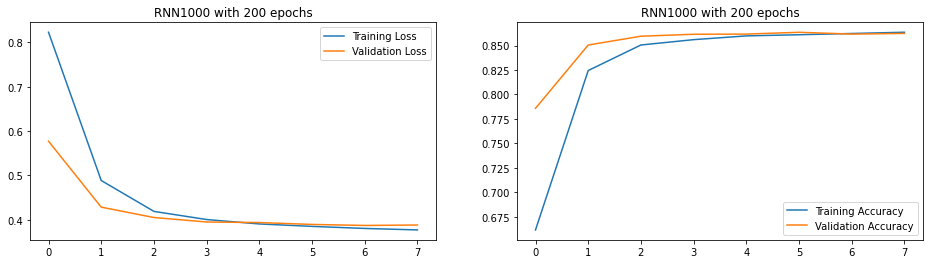

In [33]:
RNN1000 = creat_model(encoder1000)
result1000 = compile_train_model(RNN1000, 200)

In [34]:
result1000['vocab_size'] = VOCAB_SIZE 
result1000['num_words'] = num_words 
result1000['num_articles'] = num_articles
result1000['min_token_in_a_article'] = min_token_in_a_article 
result1000['max_token_in_a_article'] = max_token_in_a_article 

In [35]:
assignment_result_table = result1000
new_col = ['RNN with 1000 vocab size']   
assignment_result_table.insert(loc=0, column='Model', value=new_col)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
7,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.75678,200,8,1000,114000,1782,16,64


### Vocab 2000

In [22]:
VOCAB_SIZE = 2000
EPOCH_SIZE = 200
encoder2000 = get_encoder(VOCAB_SIZE)

In [23]:
corpus2000, doc_sizes2000 = explore_vocab(train_dataset,encoder2000)

In [24]:
vocab2000 = np.array(encoder2000.get_vocabulary())
num_vocab_words_in_corpus =len(vocab2000)

num_words =len(corpus2000)
num_articles =len(doc_sizes2000)
min_token_in_a_article = min(doc_sizes2000)
max_token_in_a_article = max(doc_sizes2000)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

"""
plt.figure(figsize=(15,9))
plt.hist(doc_sizes2000, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");
"""

2000
114000
1782
16
64


'\nplt.figure(figsize=(15,9))\nplt.hist(doc_sizes2000, bins=20,range = (0,120))\nplt.xlabel("Tokens Per Document")\nplt.ylabel("Number of AG News Articles");\n'

Epoch 1/200
1782/1782 [==============================] - 273s 148ms/step - loss: 0.6885 - accuracy: 0.7366 - val_loss: 0.4309 - val_accuracy: 0.8547
Epoch 2/200
1782/1782 [==============================] - 261s 146ms/step - loss: 0.4052 - accuracy: 0.8592 - val_loss: 0.3928 - val_accuracy: 0.8678
Epoch 3/200
1782/1782 [==============================] - 260s 146ms/step - loss: 0.3753 - accuracy: 0.8699 - val_loss: 0.3818 - val_accuracy: 0.8687
Epoch 4/200
1782/1782 [==============================] - 259s 145ms/step - loss: 0.3575 - accuracy: 0.8744 - val_loss: 0.3658 - val_accuracy: 0.8750
Epoch 5/200
1782/1782 [==============================] - 258s 145ms/step - loss: 0.3444 - accuracy: 0.8791 - val_loss: 0.3608 - val_accuracy: 0.8758
Epoch 6/200
1782/1782 [==============================] - 257s 144ms/step - loss: 0.3325 - accuracy: 0.8826 - val_loss: 0.3514 - val_accuracy: 0.8750
Epoch 7/200
1782/1782 [==============================] - 258s 145ms/step - loss: 0.3220 - accuracy: 0.8861

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

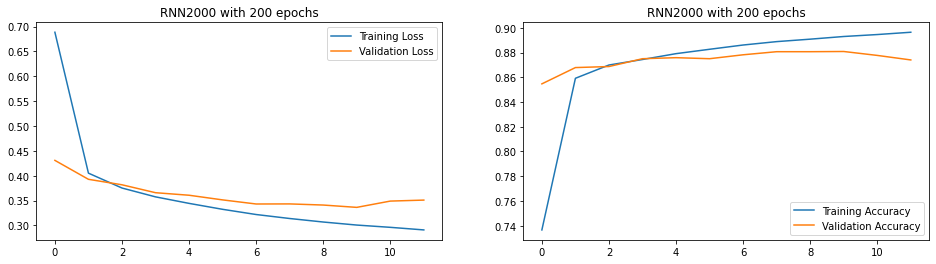

In [25]:
RNN2000 = creat_model(encoder2000)
result2000 = compile_train_model(RNN2000, 200)

In [26]:
result2000['vocab_size'] = VOCAB_SIZE 
result2000['num_words'] = num_words 
result2000['num_articles'] = num_articles
result2000['min_token_in_a_article'] = min_token_in_a_article 
result2000['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['RNN with 2000 vocab size']   
result2000.insert(loc=0, column='Model', value=new_col)

In [36]:
#assignment_result_table = pd.read_pickle('resultsAa.pkl')

In [37]:
assignment_result_table = assignment_result_table.append(result2000, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64


### Vocab 3000

In [38]:
VOCAB_SIZE = 3000
EPOCH_SIZE = 200
encoder3000 = get_encoder(VOCAB_SIZE)

In [39]:
corpus3000, doc_sizes3000 = explore_vocab(train_dataset,encoder3000)

In [40]:
vocab3000 = np.array(encoder3000.get_vocabulary())
num_vocab_words_in_corpus =len(vocab3000)

num_words =len(corpus3000)
num_articles =len(doc_sizes3000)
min_token_in_a_article = min(doc_sizes3000)
max_token_in_a_article = max(doc_sizes3000)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

"""
plt.figure(figsize=(15,9))
plt.hist(doc_sizes3000, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");
"""

3000
114000
1782
16
64


'\nplt.figure(figsize=(15,9))\nplt.hist(doc_sizes3000, bins=20,range = (0,120))\nplt.xlabel("Tokens Per Document")\nplt.ylabel("Number of AG News Articles");\n'

Epoch 1/200
1782/1782 [==============================] - 272s 147ms/step - loss: 0.6676 - accuracy: 0.7549 - val_loss: 0.4440 - val_accuracy: 0.8488
Epoch 2/200
1782/1782 [==============================] - 260s 146ms/step - loss: 0.3677 - accuracy: 0.8760 - val_loss: 0.3461 - val_accuracy: 0.8833
Epoch 3/200
1782/1782 [==============================] - 257s 144ms/step - loss: 0.3182 - accuracy: 0.8910 - val_loss: 0.3367 - val_accuracy: 0.8865
Epoch 4/200
1782/1782 [==============================] - 258s 145ms/step - loss: 0.2959 - accuracy: 0.8971 - val_loss: 0.3184 - val_accuracy: 0.8880
Epoch 5/200
1782/1782 [==============================] - 259s 145ms/step - loss: 0.2830 - accuracy: 0.9005 - val_loss: 0.3154 - val_accuracy: 0.8908
Epoch 6/200
1782/1782 [==============================] - 261s 146ms/step - loss: 0.2744 - accuracy: 0.9032 - val_loss: 0.3149 - val_accuracy: 0.8890
Epoch 7/200
119/119 [==============================] - 5s 41ms/step - loss: 0.3292 - accuracy: 0.8843
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

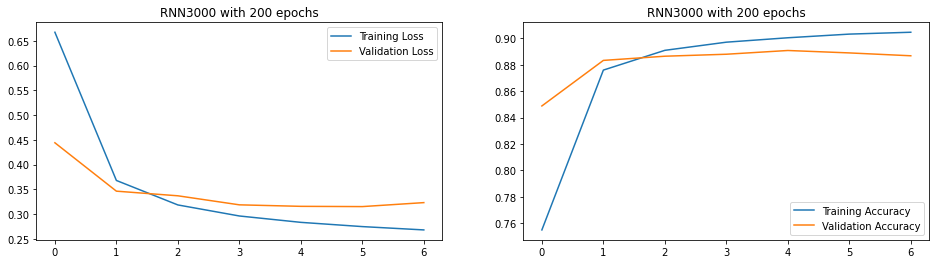

In [41]:
RNN3000 = creat_model(encoder3000)
result3000 = compile_train_model(RNN3000, 200)

In [42]:
result3000['vocab_size'] = VOCAB_SIZE 
result3000['num_words'] = num_words 
result3000['num_articles'] = num_articles
result3000['min_token_in_a_article'] = min_token_in_a_article 
result3000['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['RNN with 3000 vocab size']   
result3000.insert(loc=0, column='Model', value=new_col)

In [43]:
assignment_result_table = assignment_result_table.append(result3000, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64


In [44]:
assignment_result_table.to_pickle("resultsA.pkl") 
assignment_result_table.to_csv("resultsA.csv") 

### Plot Test Accuracy by Vocab Size

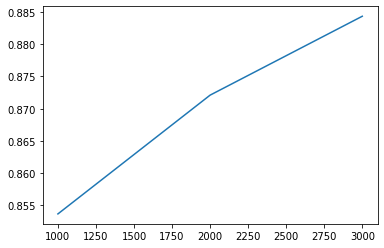

In [45]:
x= assignment_result_table['vocab_size']
y= assignment_result_table['test_accuracy']
plt.plot(x,y)

## Experiment A b
(b) Editing the Vocabulary: Try unedited most frequent words, VERSUS edit the list by deleting the most frequent words such as article, ‘the’, ‘a’, etc.

### Deleting the most frequent words from vocab

In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [50]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [51]:
vocab1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [52]:
filtered_vocab1000= []
for w in vocab1000:
    if w not in stopwords:
        filtered_vocab1000.append(w)

In [53]:
filtered_vocab1000[:20]

['',
 '[UNK]',
 '39s',
 'said',
 'new',
 'us',
 'reuters',
 'ap',
 'two',
 'first',
 'monday',
 'wednesday',
 'tuesday',
 'thursday',
 'company',
 'friday',
 'inc',
 'one',
 'world',
 'yesterday']

In [54]:
len(filtered_vocab1000)

898

In [55]:
def get_encoder_with_filtered_vocab(VOCAB_SIZE, VOCAB):
  encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, vocabulary=VOCAB)
  #encoder.adapt(train_dataset.map(lambda text, label: text)) # Because we've passed the vocabulary directly, we don't need to adapt the layer - the vocabulary is already set. 
  return encoder

In [56]:
VOCAB_SIZE = 1000
EPOCH_SIZE = 200
VOCAB = filtered_vocab1000 
encoder1000_vocab = get_encoder_with_filtered_vocab(VOCAB_SIZE, VOCAB)

In [57]:
corpus1000_vocab, doc_sizes1000_vocab = explore_vocab(train_dataset,encoder1000_vocab)

In [58]:
vocab1000_50 = np.array(encoder1000_vocab.get_vocabulary())
num_vocab_words_in_corpus =len(vocab1000_50)

num_words =len(corpus1000_vocab)
num_articles =len(doc_sizes1000_vocab)
min_token_in_a_article = min(doc_sizes1000_vocab)
max_token_in_a_article = max(doc_sizes1000_vocab)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

"""
plt.figure(figsize=(15,9))
plt.hist(doc_sizes1000_vocab, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
"""

898
114000
1782
16
64


'\nplt.figure(figsize=(15,9))\nplt.hist(doc_sizes1000_vocab, bins=20,range = (0,120))\nplt.xlabel("Tokens Per Document")\nplt.ylabel("Number of AG News Articles")\n'

Epoch 1/200
1782/1782 [==============================] - 272s 146ms/step - loss: 0.8172 - accuracy: 0.6636 - val_loss: 0.5888 - val_accuracy: 0.7852
Epoch 2/200
1782/1782 [==============================] - 254s 143ms/step - loss: 0.5296 - accuracy: 0.8058 - val_loss: 0.4794 - val_accuracy: 0.8357
Epoch 3/200
1782/1782 [==============================] - 254s 142ms/step - loss: 0.4584 - accuracy: 0.8344 - val_loss: 0.4343 - val_accuracy: 0.8475
Epoch 4/200
1782/1782 [==============================] - 255s 143ms/step - loss: 0.4203 - accuracy: 0.8471 - val_loss: 0.4231 - val_accuracy: 0.8495
Epoch 5/200
1782/1782 [==============================] - 257s 144ms/step - loss: 0.4058 - accuracy: 0.8522 - val_loss: 0.4131 - val_accuracy: 0.8520
Epoch 6/200
1782/1782 [==============================] - 256s 143ms/step - loss: 0.3975 - accuracy: 0.8553 - val_loss: 0.4110 - val_accuracy: 0.8517
Epoch 7/200
1782/1782 [==============================] - 255s 143ms/step - loss: 0.3918 - accuracy: 0.8566

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

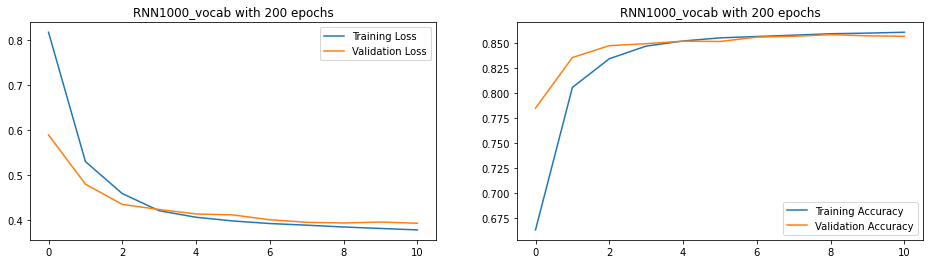

In [59]:
RNN1000_vocab = creat_model(encoder1000_vocab)
result1000_vocab = compile_train_model(RNN1000_vocab, 200)

In [60]:
result1000_vocab['vocab_size'] = num_vocab_words_in_corpus 
result1000_vocab['num_words'] = num_words 
result1000_vocab['num_articles'] = num_articles
result1000_vocab['min_token_in_a_article'] = min_token_in_a_article 
result1000_vocab['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['RNN with filtered vocab that deleting the most frequent words']   
result1000_vocab.insert(loc=0, column='Model', value=new_col)
#result1000_vocab

In [61]:
assignment_result_table = assignment_result_table.append(result1000_vocab, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64


## Experiment A c
(c) Output sequence length: Use the default VERSUS set it to a fixed number

### Output sequence length

In [62]:
def get_encoder_with_seq_length(VOCAB_SIZE, SEQ_LENGTH):
  encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=SEQ_LENGTH)
  encoder.adapt(train_dataset.map(lambda text, label: text))
  return encoder

In [63]:
VOCAB_SIZE = 1000
EPOCH_SIZE = 200
SEQ_LENGTH = 50 
encoder1000_50 = get_encoder_with_seq_length(VOCAB_SIZE, SEQ_LENGTH)

In [64]:
corpus1000_50, doc_sizes1000_50 = explore_vocab(train_dataset,encoder1000_50)

In [65]:
vocab1000_50 = np.array(encoder1000_50.get_vocabulary())
num_vocab_words_in_corpus =len(vocab1000_50)

num_words =len(corpus1000_50)
num_articles =len(doc_sizes1000_50)
min_token_in_a_article = min(doc_sizes1000_50)
max_token_in_a_article = max(doc_sizes1000_50)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

"""
plt.figure(figsize=(15,9))
plt.hist(doc_sizes1000_50, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles")
"""

1000
114000
1782
16
64


'\nplt.figure(figsize=(15,9))\nplt.hist(doc_sizes1000_50, bins=20,range = (0,120))\nplt.xlabel("Tokens Per Document")\nplt.ylabel("Number of AG News Articles")\n'

Epoch 1/200
1782/1782 [==============================] - 207s 111ms/step - loss: 0.6840 - accuracy: 0.7419 - val_loss: 0.4917 - val_accuracy: 0.8300
Epoch 2/200
1782/1782 [==============================] - 196s 110ms/step - loss: 0.4671 - accuracy: 0.8335 - val_loss: 0.4691 - val_accuracy: 0.8377
Epoch 3/200
1782/1782 [==============================] - 196s 110ms/step - loss: 0.4480 - accuracy: 0.8391 - val_loss: 0.4501 - val_accuracy: 0.8402
Epoch 4/200
1782/1782 [==============================] - 196s 110ms/step - loss: 0.4368 - accuracy: 0.8429 - val_loss: 0.4403 - val_accuracy: 0.8412
Epoch 5/200
1782/1782 [==============================] - 196s 110ms/step - loss: 0.4247 - accuracy: 0.8468 - val_loss: 0.4265 - val_accuracy: 0.8462
Epoch 6/200
1782/1782 [==============================] - 195s 110ms/step - loss: 0.4119 - accuracy: 0.8518 - val_loss: 0.4145 - val_accuracy: 0.8505
Epoch 7/200
1782/1782 [==============================] - 196s 110ms/step - loss: 0.3996 - accuracy: 0.8550

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

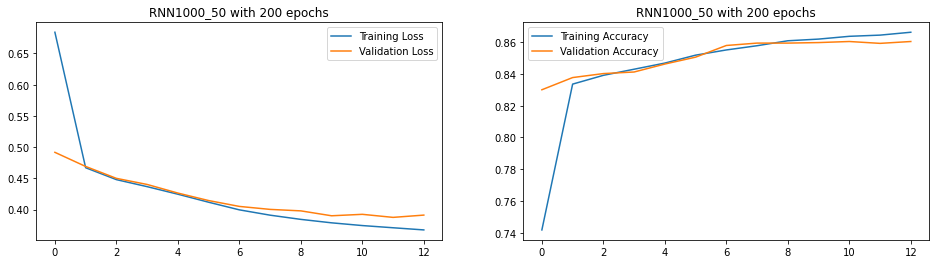

In [66]:
RNN1000_50 = creat_model(encoder1000_50)
result1000_50 = compile_train_model(RNN1000_50, 200)

In [67]:
result1000_50['vocab_size'] = VOCAB_SIZE 
result1000_50['num_words'] = num_words 
result1000_50['num_articles'] = num_articles
result1000_50['min_token_in_a_article'] = min_token_in_a_article 
result1000_50['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['RNN with 1000 vocab size 50 output sequence length']   
result1000_50.insert(loc=0, column='Model', value=new_col)
#result1000_50

In [68]:
assignment_result_table = assignment_result_table.append(result1000_50, ignore_index = True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64


## Save data

In [73]:
assignment_result_table.to_pickle("resultsA.pkl") 
assignment_result_table.to_csv("resultsA.csv") 

In [76]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [77]:
assignment_result_table.to_pickle('/content/gdrive/My Drive/Colab Notebooks/resultsA.pkl')
assignment_result_table.to_csv('/content/gdrive/My Drive/Colab Notebooks/resultsA.csv')